In [1]:
import torch
import numpy as np
import cv2
from PIL import Image
from IPython.display import display

from diffusers import (
    StableDiffusionXLControlNetImg2ImgPipeline,
    ControlNetModel,
    AutoencoderKL,
)
from diffusers.utils import load_image

# make things go fast like vroom https://huggingface.co/docs/diffusers/en/optimization/fp16
# https://www.felixsanz.dev/articles/ultimate-guide-to-optimizing-stable-diffusion-xl
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True 

device = "cuda"

# 1. Load base SDXL, VAE, and a ControlNet (Canny here)
print("Loading ControlNet")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",  # or another SDXL controlnet
    torch_dtype=torch.float16,
    use_safetensors=True,
)
print("Loading VAE")
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sdxl-vae",  # optional: better VAE for SDXL
    torch_dtype=torch.float16,
)
print("Loading SDXL")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

pipe = pipe.to(device, dtype=torch.float16)
pipe.enable_xformers_memory_efficient_attention()
# for some reason if I compile the unet it stops image generation from working
# pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
# pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead")



c:\Users\dzluk\emergent-image\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\dzluk\emergent-image\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


Loading ControlNet
Loading VAE
Loading SDXL


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Generating image...


  0%|          | 0/15 [00:00<?, ?it/s]

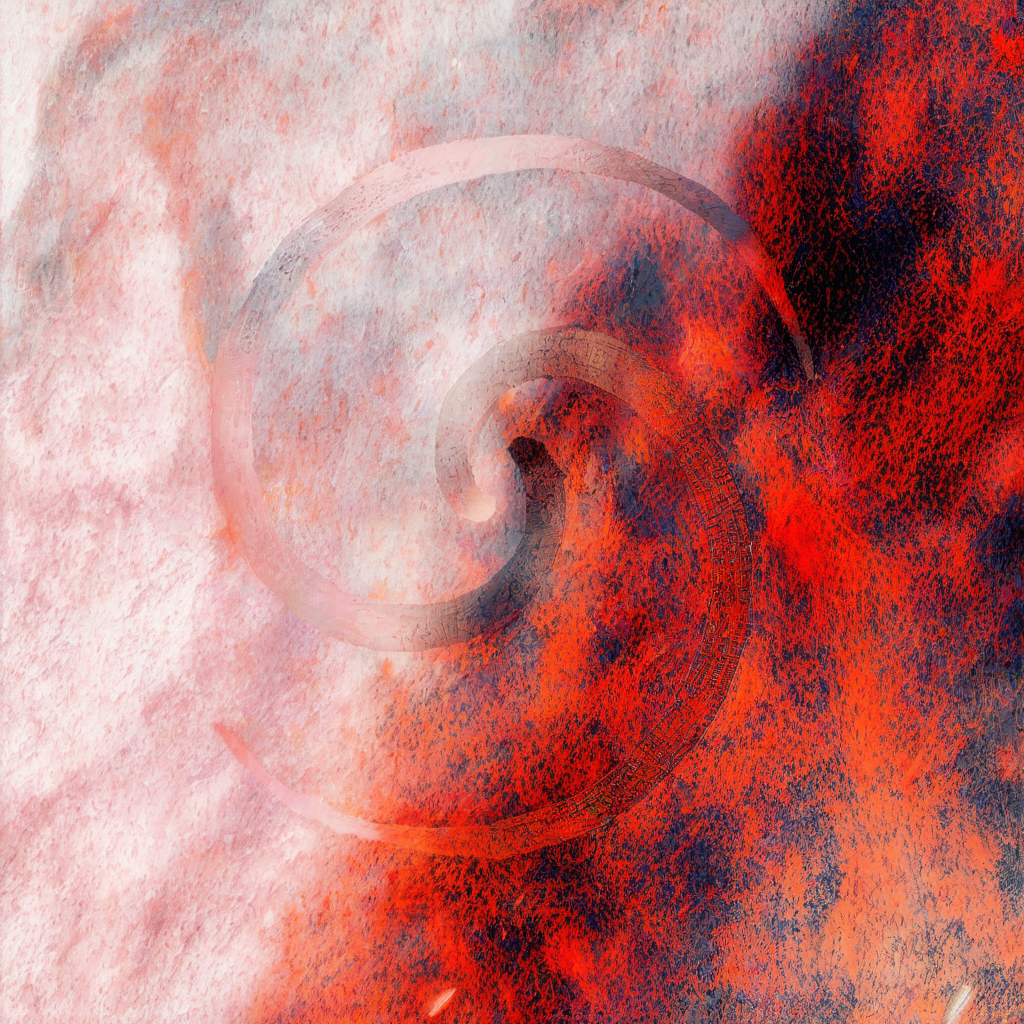

In [ ]:
# 2. Load the *source* image for img2img
init_image = load_image("inputs/google-earth-view-12658.jpg").convert("RGB")

# resize to a multiple of 8
init_image = init_image.resize((1024, 1024), Image.LANCZOS)

# 3. Build a Canny control image 
# load the canny image
canny_image = load_image("inputs/spiral.png").convert("RGB")
# resize to a multiple of 8
canny_image = canny_image.resize((1024, 1024), Image.LANCZOS)
canny_source = np.array(canny_image)
canny = cv2.Canny(canny_source, 100, 200)
canny = canny[:, :, None]
canny = np.concatenate([canny, canny, canny], axis=2)

control_image = Image.fromarray(canny)
control_image.save("canny_control.png")

# 4. Define prompts and strength
prompt = "highly detailed satellite image"
negative_prompt = "low quality, blurry, distorted"
strength = 0.5        # img2img strength (how far to move from init)
controlnet_conditioning_scale = 1.0  # ControlNet weight

# 5. Run img2img + ControlNet in one call
print("Generating image...")
result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,                     # img2img input
    control_image=control_image,          # ControlNet conditioning image
    num_inference_steps=30,
    guidance_scale=5.0,
    strength=strength,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
)

out_image = result.images[0]
out_image.save("sdxl_img2img_controlnet.png")
display(out_image)
